In [1]:
from sktime.forecasting.arima import AutoARIMA
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sktime.forecasting.fbprophet import Prophet as skProphet
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError as MAPE
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import seasonal_decompose, STL

Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.filterwarnings("ignore") 

In [3]:
def max_sin_0(x):
    return max(np.sin(x), 0)

In [4]:
def get_pred_3y(df, start_date, end_date, column='close', model='ARIMA', **params):
    y = df.loc[(df.index > pd.to_datetime(start_date))&(df.index < pd.to_datetime(end_date))]
    y = y[column]
    if model.upper() == 'ARIMA':
        model = AutoARIMA(start_p=1, start_q=1, D=1, sp=12, seasonal=True, stationary=False)
    elif model.title() == 'Prophet':
        model = skProphet(freq='M', yearly_seasonality='auto', weekly_seasonality=False, daily_seasonality=False)
    else:
        raise TypeError("Wrong model proveded. It must be 'ARIMA' or 'Prophet'. ")
    model.set_params(**params)
    model.fit(y)
    fh = pd.date_range(y.index[-1] + DateOffset(months=1), freq='M', periods=36)
    y_pred = model.predict(fh)
    return y, y_pred

In [5]:
def prophet_adjust(y, interval_width=0.8):
    prophet_mod = Prophet(yearly_seasonality='auto', seasonality_mode='additive', 
                          interval_width=interval_width)
    y_proph = y.reset_index()
    y_proph.columns = ['ds', 'y']
    prophet_mod.fit(y_proph)
    pred = prophet_mod.predict(y_proph)[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
    pred['actual'] = y_proph['y']
    pred['is_outlier'] = (pred['actual'] < pred['yhat_lower']) | (pred['actual'] > pred['yhat_upper'])
    pred['adjusted'] = pred['actual'].mask(pred['is_outlier'], pred['yhat'])
    return pred.set_index('ds').asfreq('M')

In [6]:
def load_series(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df.asfreq('M')

# Uznanie przez model outliera za sezonowość

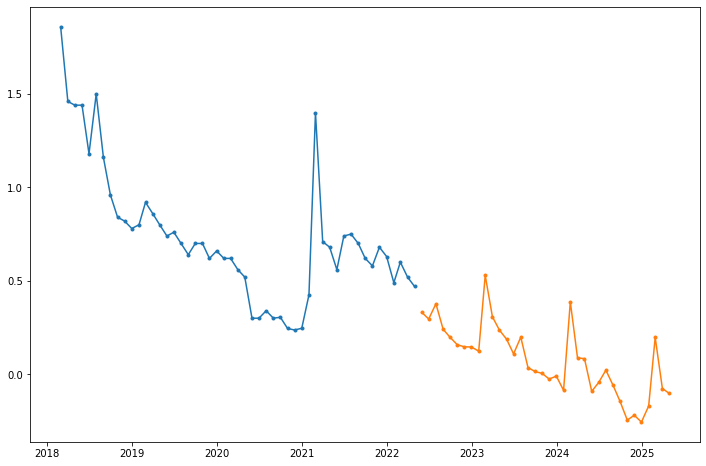

In [7]:
series = '1027_hk_m.csv'#"pko_m.csv" # 'wig_paliwa_m.csv'
df = load_series('./data/' + series)
# create fake outlier
df.loc[df.index==pd.to_datetime('2021-02-28'), 'close'] = 1.4

# create model using fake outlier
start, stop = '2017-01-01', '2022-05-01'
y, y_pred = get_pred_3y(df, start, stop, model='Prophet') # ARIMA i trend='n'

# plot
plt.figure(figsize=(12,8))
plt.plot(y, marker='.', label='data')
plt.plot(y_pred, marker='.', label = 'predicted data')
plt.show()

# Zaniżenie / zawyżenie predykcji w skutek występowania outlierów na końcu szeregu  

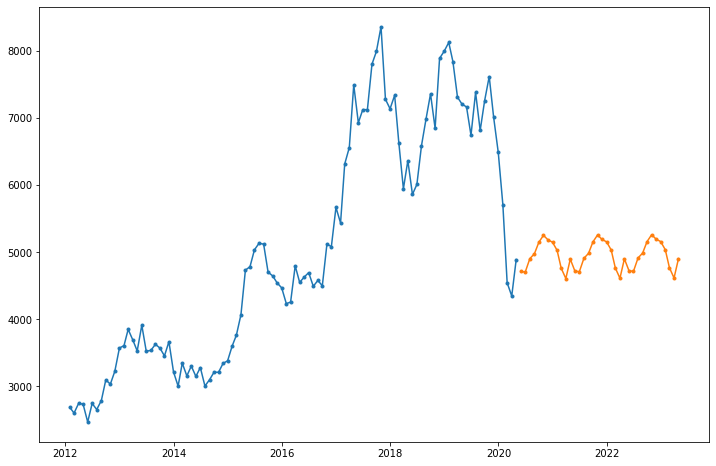

In [8]:
series = 'wig_paliwa_m.csv'#"pko_m.csv" # 'wig_paliwa_m.csv'
df = load_series('./data/' + series)
start, stop = '2012-01-01', '2020-05-01'
y, y_pred = get_pred_3y(df, start, stop)
plt.figure(figsize=(12,8))
plt.plot(y, marker='.')
plt.plot(y_pred, marker='.')
plt.show()

# Zawyżenie / zaniżenie trendu

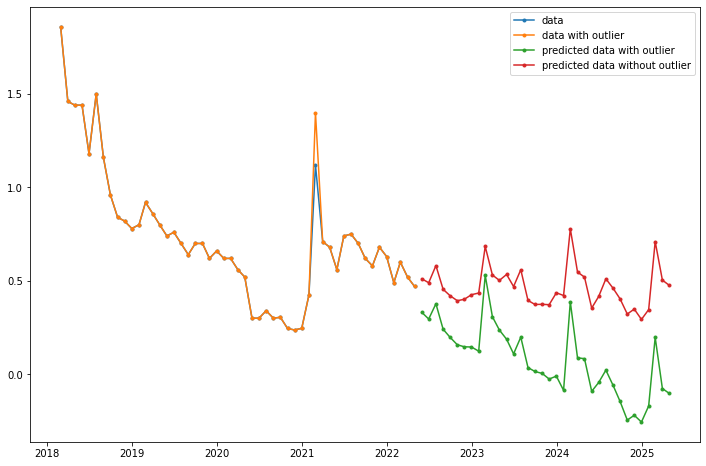

In [9]:
series = '1027_hk_m.csv'#"pko_m.csv" # 'wig_paliwa_m.csv'
df = load_series('./data/' + series)
# create fake outlier
original_value = df.loc[df.index==pd.to_datetime('2021-02-28'), 'close']
df.loc[df.index==pd.to_datetime('2021-02-28'), 'close'] = 1.4

# create model using fake outlier
start, stop = '2017-01-01', '2022-05-01'
y_out, y_pred_out = get_pred_3y(df, start, stop, model='Prophet') 

# come back to original value
df.loc[df.index==pd.to_datetime('2021-02-28'), 'close'] = original_value
y, y_pred = get_pred_3y(df, start, stop, model='Prophet') 

# plot
plt.figure(figsize=(12,8))
plt.plot(y, marker='.', label='data')
plt.plot(y_out, marker='.', label='data with outlier')
plt.plot(y_pred_out, marker='.', label = 'predicted data with outlier')
plt.plot(y_pred, marker='.', label = 'predicted data without outlier')
plt.legend()
plt.show()

# Zidentyfikowanie sezonowości jako outliera 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


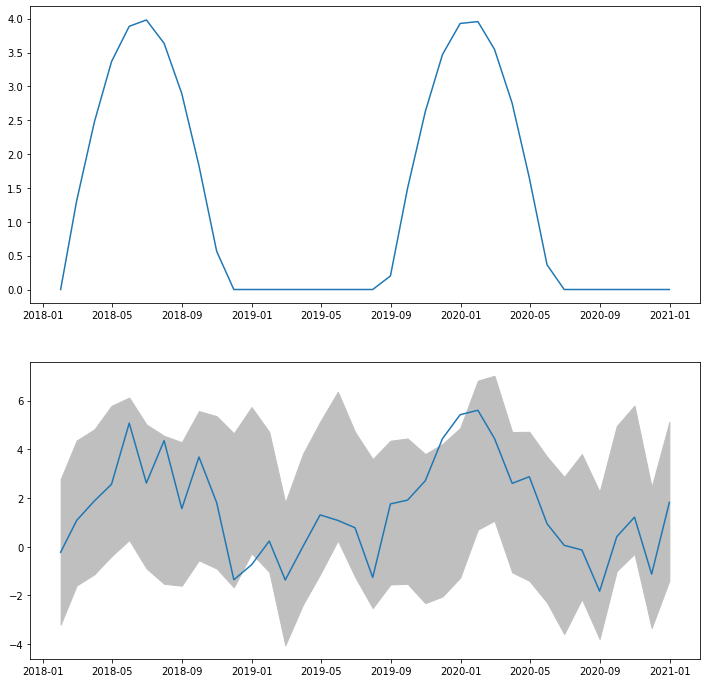

In [10]:
# generate fake data
x = np.arange(36)
np.random.seed(90)
y = np.array(list(map(max_sin_0, x/3)))*4 + np.random.normal(0, 1, 36)
date = pd.date_range('2018-01-01', freq='M', periods=36)
y = pd.DataFrame({'sin': y}, index=date)

# catch outliers
proph_adj = prophet_adjust(y, 0.95)

# plot
fig, ax = plt.subplots(2, 1, figsize=(12,12))
ax[0].plot(date, np.array(list(map(max_sin_0, x/3)))*4)
ax[1].plot(proph_adj[['actual']])
ax[1].fill_between(proph_adj.index, proph_adj['yhat_lower'], proph_adj['yhat_upper'], color='#bfbfbf')

# ⬅️⬅️⬅️⬅️⬅️⬅️

# Dlaczego klasyczne metody się nie sprawdzą? 

## Metoda 3-$\sigma$

In [11]:
series = '1027_hk_m.csv'#"pko_m.csv" # 'wig_paliwa_m.csv'
df = load_series('./data/' + series)
# create fake outlier
df.loc[df.index==pd.to_datetime('2021-02-28'), 'close'] = 1.4

y = df['close']

<AxesSubplot:>

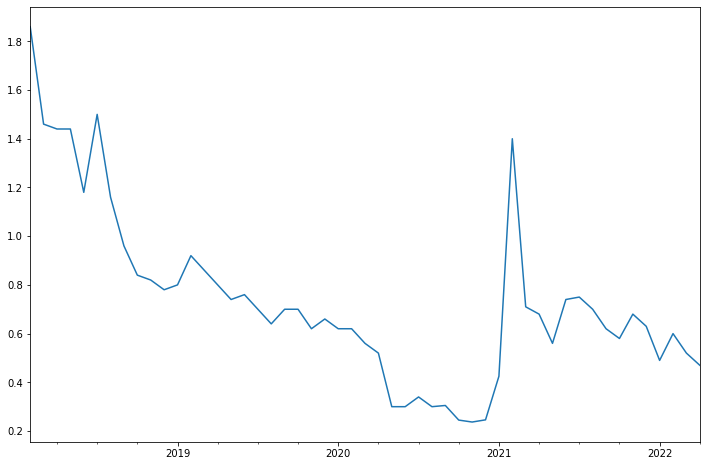

In [39]:
y.plot(figsize=(12,8))

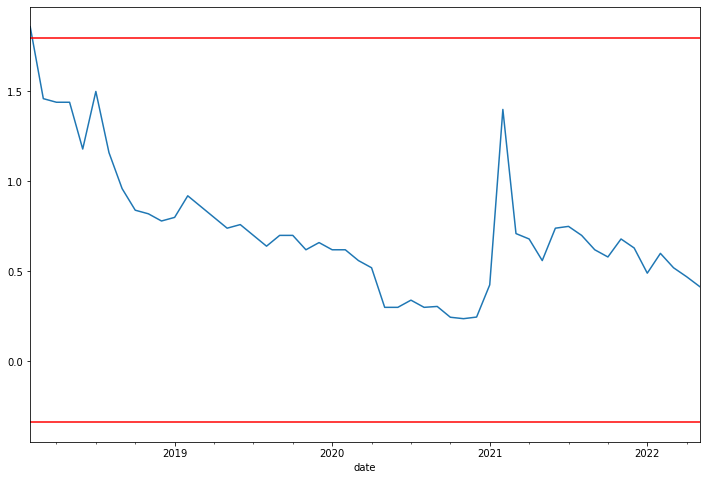

In [12]:
mu, std = norm.fit(y) 

lower = mu - 3 * std
upper = mu + 3 * std

# zasada 3 sigma
y.plot(figsize=(12,8))
plt.axhline(lower, color='r')
plt.axhline(upper, color='r')

# ⬅️⬅️⬅️⬅️⬅️⬅️

# Wykorzystanie dekompozycji

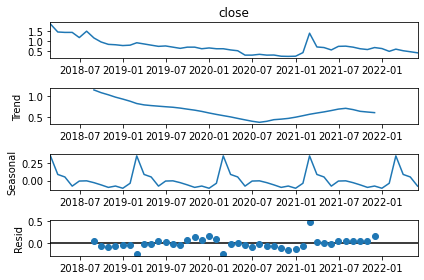

In [13]:
result = seasonal_decompose(y, model='additive')
result.plot()
plt.show()

In [14]:
# fill only right part - beginning won't change too much so makes sense to leave as nan
trend = result.trend
trend = trend.fillna(trend.rolling(6, min_periods=1).mean())
trend = trend.fillna(trend.rolling(6, min_periods=1).mean())

In [15]:
residuals = result.observed - trend - result.seasonal

### Metoda 3 sigma 

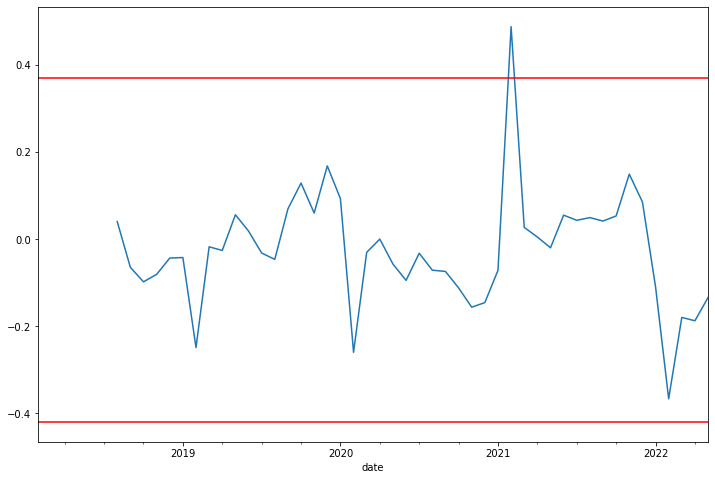

In [16]:
mu, std = norm.fit(residuals.dropna()) 

lower = mu - 3 * std
upper = mu + 3 * std

# zasada 3 sigma
residuals.plot(figsize=(12,8))
plt.axhline(lower, color='r')
plt.axhline(upper, color='r')

## Metoda IQR

In [17]:
def IQR(datacolumn):
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

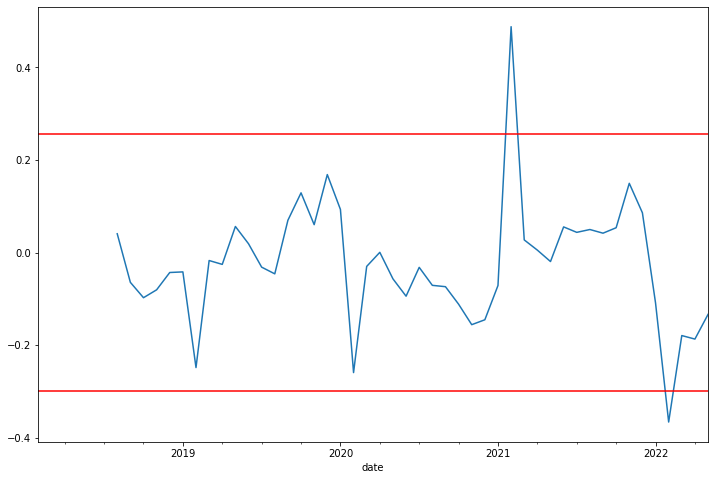

In [18]:
lower, upper = IQR(residuals.dropna())

residuals.plot(figsize=(12,8))
plt.axhline(lower, color='r')
plt.axhline(upper, color='r')

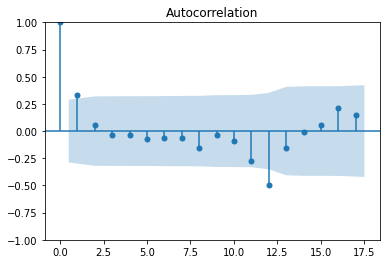

In [19]:
# independence
plot_acf(residuals.dropna())
plt.show()

In [20]:
y = pd.DataFrame(y)

In [21]:
y['is_outlier'] =  (residuals < lower)| (residuals > upper)

In [22]:
outliers = y['close'].where(y['is_outlier']).dropna()

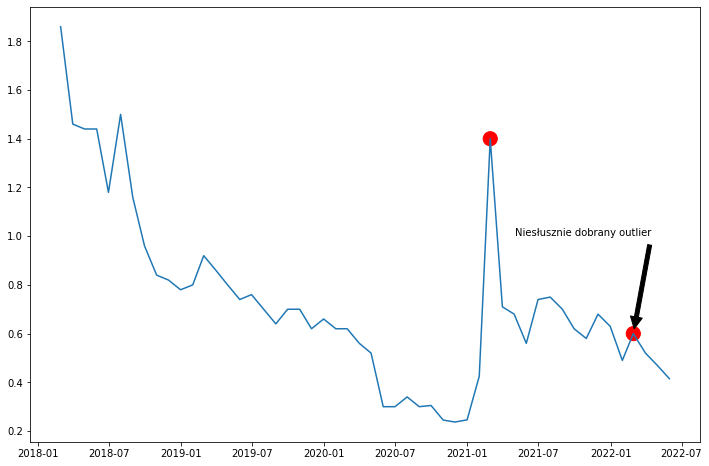

In [23]:
plt.figure(figsize=(12,8))
plt.plot(y['close'])
plt.scatter(outliers.index, outliers.values, color='red', s=[200]*outliers.shape[0])
plt.annotate('Niesłusznie dobrany outlier', (outliers.index[1], outliers.values[1]), 
             (pd.to_datetime('2021-05-01'), 1.0), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# STL - dekompozycja korzystając z metody Loess 
- Loess - lokalna regresja wielomianowa, wykorzystywana m.in. do wygładzania szeregów. Generalizacja ruchomej średniej i regresji wielomianowej


In [24]:
series = 'wig_paliwa_m.csv' 
df = load_series('./data/' + series)

start, stop = '2012-01-01', '2022-05-01'
y, y_pred = get_pred_3y(df, start, stop, model='Prophet') # ARIMA i trend='n'

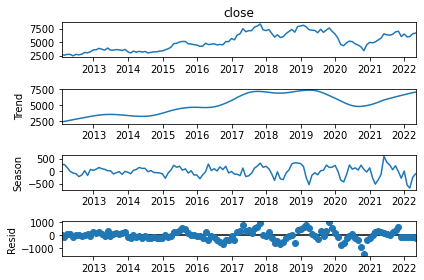

In [25]:
result = STL(y).fit()
result.plot()
plt.show()

In [26]:
residuals = result.resid


### Metoda 3-sigma

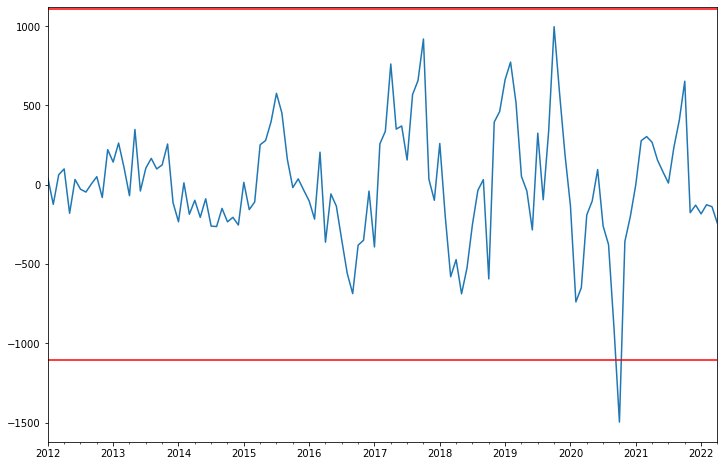

In [27]:
mu, std = norm.fit(residuals.dropna()) 

lower = mu - 3 * std
upper = mu + 3 * std

# zasada 3 sigma
residuals.plot(figsize=(12,8))
plt.axhline(lower, color='r')
plt.axhline(upper, color='r')

### Metoda IQR

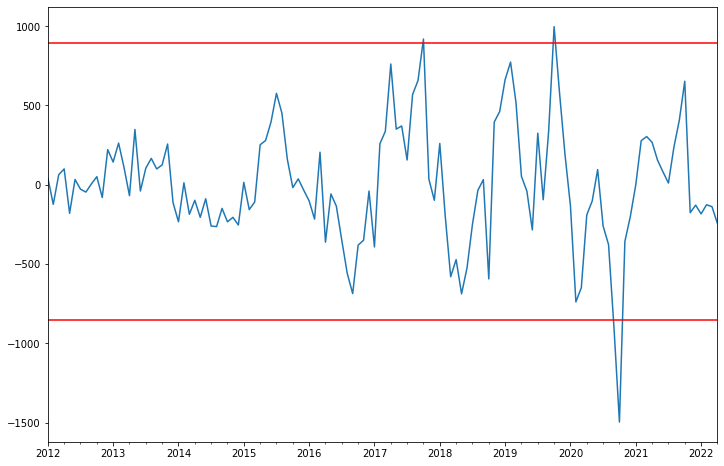

In [28]:
lower, upper = IQR(residuals.dropna())

residuals.plot(figsize=(12,8))
plt.axhline(lower, color='r')
plt.axhline(upper, color='r')

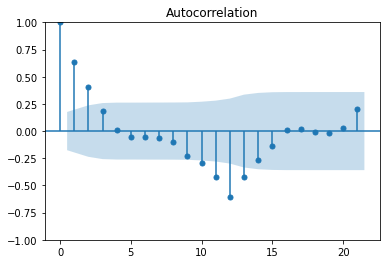

In [29]:
# some autocorrecations on residuals 
plot_acf(residuals)
plt.show()

### Efekt ten nie pojawia się gdy wykorzystamy klasyczną dekompozycję

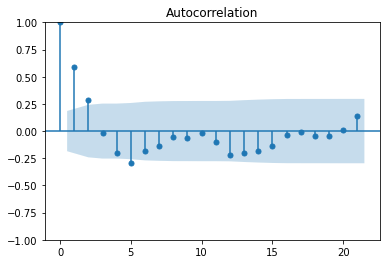

In [30]:
result = seasonal_decompose(y, model='additive')
plot_acf(result.resid.dropna())
plt.show()

# ⬅️⬅️⬅️⬅️⬅️⬅️

# Pozytywny wpływ redukcji outlierów na predykcję 

### Outliery na końcu 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


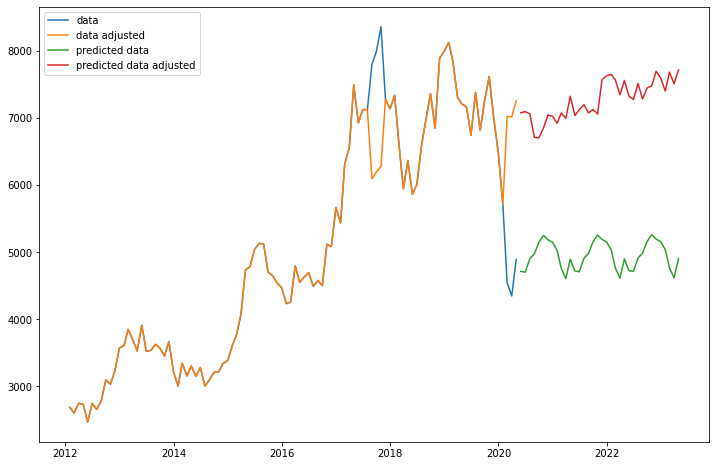

In [36]:
series = 'wig_paliwa_m.csv' 
df = load_series('./data/' + series)

start, stop = '2012-01-01', '2020-05-01'
y, y_pred = get_pred_3y(df, start, stop, trend='n') 

proph_adj = prophet_adjust(y, 0.95)
y_adj, y_pred_adj = get_pred_3y(proph_adj, start, stop, column='adjusted', trend='n')
plt.figure(figsize=(12,8))
plt.plot(y, label='data') 
plt.plot(y_adj, label='data adjusted') 
plt.plot(y_pred, label = 'predicted data')
plt.plot(y_pred_adj, label = 'predicted data adjusted')
plt.legend()
plt.show()

### Outliery znacząco wpływające na  trend ogólny

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


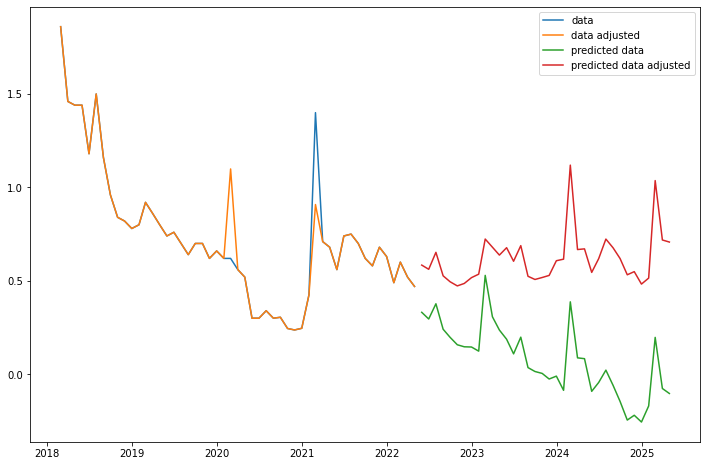

In [38]:
series = '1027_hk_m.csv'#"pko_m.csv" # 'wig_paliwa_m.csv'
df = load_series('./data/' + series)
# create fake outlier
original_value = df.loc[df.index==pd.to_datetime('2021-02-28'), 'close']
df.loc[df.index==pd.to_datetime('2021-02-28'), 'close'] = 1.4

# create model using fake outlier
start, stop = '2017-01-01', '2022-05-01'
y, y_pred = get_pred_3y(df, start, stop, model='Prophet') 

# adjust
proph_adj = prophet_adjust(y, 0.95)
y_adj, y_pred_adj = get_pred_3y(proph_adj, start, stop, column='adjusted', model='Prophet')

# plot
plt.figure(figsize=(12,8))
plt.plot(y, label='data') 
plt.plot(y_adj, label='data adjusted') 
plt.plot(y_pred, label = 'predicted data')
plt.plot(y_pred_adj, label = 'predicted data adjusted')
plt.legend()
plt.show()